# TABLE OF CONTENTS:
---
* [Notebook Summary](#Notebook-Summary)
* [Setup](#Setup)
    * [Notebook Parameters](#Notebook-Parameters)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Retrieve the Registered Model](#Retrieve-the-Registered-Model)
* [Retrieve the Registered Inference Environment](#Retrieve-the-Registered-Inference-Environment)
* [Inference Artifacts & Configuration](#Inference-Artifacts-&-Configuration)
* [Model Deployment (Local)](#Model-Deployment-(Local))
    * [Initial Local Deployment](#Initial-Local-Deployment)
    * [Update Local Deployment](#Update-Local-Deployment)
    * [Local Webservice Testing](#Local-Webservice-Testing)
    * [Local Webservice Clean Up](#Local-Webservice-Clean-Up)
* [Model Deployment (Compute Target)](#Model-Deployment-(Compute-Target))
    * [Option 1: Deploy to ACI (Azure Container Instances)](#Option-1:-Deploy-to-ACI-(Azure-Container-Instances))
        * [ACI Webservice Testing](#ACI-Webservice-Testing)
        * [ACI Webservice Clean Up](#ACI-Webservice-Clean-Up)
    * [Option 2: Deploy to AKS (Azure Kubernetes Service)](#Option-2:-Deploy-to-AKS-(Azure-Kubernetes-Service))
        * [AKS Webservice Testing](#AKS-Webservice-Testing)
        * [AKS Webservice Clean Up](#AKS-Webservice-Clean-Up)
* [Model Deployment (Docker Image)](#Model-Deployment-(Docker-Image)) 
    * [Model Packaging](#Model-Packaging)
        * [Option 1: Download a Packaged Model](#Option-1:-Download-a-Packaged-Model)
        * [Option 2: Generate a Dockerfile](#Option-2:-Generate-a-Dockerfile)   
        * [Model Packaging Local Deployment](#Model-Packaging-Local-Deployment)
        * [Model Packaging Local Webservice Testing](#Model-Packaging-Local-Webservice-Testing)
        * [Model Packaging Clean Up](#Model-Packaging-Clean-Up)
    * [Deploy Docker Image to AKS](#Deploy-Docker-Image-to-AKS)
    * [Test the Deployed Webservice](#Test-the-Deployed-Webservice)
    * [Model Packaging Webservice Clean Up](#Model-Packaging-Webservice-Clean-Up)
* [Resource Clean Up](#Resource-Clean-Up)
---

# Notebook Summary

In this notebook, the Azure Machine Learning (AML) model that has been trained in the `02_model_training` notebook and evaluated in the `03_model_evaluation` notebook will be deployed. It is shown how the model can be deployed to different compute targets using different methods of the Azure Machine Learning (AML) Python SDK, one of them in combination with the Kubernetes CLI. The notebook will cover local deployment to the AML Compute Instance (CI), which is useful for debugging purposes, as well as deployment to Azure Container Instances (ACI) and Azure Kubernetes Service (AKS). ACI is a great solution for testing and debugging the MLOps workflow. For scalable production deployments, AKS should be used instead. In all of these cases, the model will be deployed as a web service, specifically as a Docker image that encapsulates the scoring logic and the model itself.

# Setup

Append parent directory to sys path to be able to import created modules from src directory.

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

Automatically reload modules when changes are made.

In [2]:
%load_ext autoreload
%autoreload 2

Import libraries and modules.

In [3]:
# Import libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision
import torchvision.transforms as transforms
from azureml.core import Environment, Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, AksWebservice, LocalWebservice, Webservice
from PIL import Image

# Import created modules
from src.utils import preprocess_image

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.20.0


### Notebook Parameters

Specify the notebook parameters which are used in the source code below.

In [4]:
# Specify the model name
model_name = "dog_clf_model"

# Specify the model version
model_version = None # None means latest

# Specify the inferencing environment name
env_name = "dogs_clf_deploy_env"

# Specify the local model path
local_model_path = "../outputs/dog_clf_model.pt"

# Specify the inference entry script path
inference_entry_script_path = "../src/deployment/score.py"

# Specify path to an example of model input data
data_example_path = "../data/val/n02085620-Chihuahua/n02085620_1152.jpg"

# Specify the local webservice name for local deployment
local_service_name = "dog-classification-service-local"

# Specify the ACI webservice name for ACI deployment
aci_service_name = "dog-classification-service-aci"

# Specify the webservice tags
service_tags = {"data": "dogs", "method": "transfer learning", "framework": "PyTorch"}

# Specify the webservice description
service_description = "Classify dogs using transfer learning with PyTorch"

# Specify the AKS cluster name
aks_name = "aks-cluster" 

# Specify the AKS webservice name for AKS deployment
aks_service_name = "dog-classification-service-aks"

# Specify the image name and image tag for model packaging 
image_name = "inference/dog_clf_model"
image_label = "1.0.0" # image tag

### Connect to Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the Azure ML SDK.

In [5]:
# Connect to the AML workspace with interactive authentication
ws = Workspace.from_config()

# Retrieve the Registered Model

Retrieve the registered model from the workspace.

In [6]:
model = Model(workspace=ws, name=model_name, version=model_version)

# Retrieve the Registered Inference Environment

Retrieve the inferencing environment from the workspace.

In [7]:
env = Environment.get(workspace=ws, name=env_name)

# Inference Artifacts & Configuration

A deployment folder for artifacts that are required for inference has been created (`<PROJECT_ROOT>/src/deployment`).

This folder contains the scoring script, called score.py, which has to be created to enable inference and is used by the web service call to show how to use the model.

Two functions are required in the scoring script:
1. an `init` function that executes once when the service starts - in this function you normally get the model from the model registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.

In addition, an inference configuration needs to be created which bundles the inference environment with the entry script and the source directory if multiple files are required for inference.

In [8]:
# Create Inference Config
inference_config = InferenceConfig(entry_script=inference_entry_script_path,
                                   environment=env)

# Model Deployment (Local)

Scenarios for local deployment include:

* Quickly iterating data, scripts, and models early in a project.
* Debugging and troubleshooting in later stages.
* Final deployment on user-managed hardware.

### Initial Local Deployment

Using Docker to deploy your model as a web service is the most common option (cell below). The other alternative is to run your code directly by using local Python scripts (load the PyTorch model file and use it for scoring similar as is done in the `03_model_evalation` notebook). For more info on this option check [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-local).

In [9]:
deployment_config = LocalWebservice.deploy_configuration(port=6789)

local_service = Model.deploy(workspace=ws,
                             name=local_service_name,
                             models=[model],
                             inference_config=inference_config,
                             deployment_config = deployment_config)

local_service.wait_for_deployment(show_output=True)

Generating Docker build context.
2021/06/28 18:06:23 Downloading source code...
2021/06/28 18:06:24 Finished downloading source code
2021/06/28 18:06:25 Creating Docker network: acb_default_network, driver: 'bridge'
2021/06/28 18:06:25 Successfully set up Docker network: acb_default_network
2021/06/28 18:06:25 Setting up Docker configuration...
2021/06/28 18:06:26 Successfully set up Docker configuration
2021/06/28 18:06:26 Logging in to registry: 4d3602983f8547aa8deaeb9718806017.azurecr.io
2021/06/28 18:06:27 Successfully logged into 4d3602983f8547aa8deaeb9718806017.azurecr.io
2021/06/28 18:06:27 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/06/28 18:06:27 Scanning for dependencies...
2021/06/28 18:06:28 Successfully scanned dependencies
2021/06/28 18:06:28 Launching container with name: acb_step_0
Sending build context to Docker daemon  67.07kB
Step 1/25 : FROM mcr.microsoft.com/azureml/o16n-base/python-assets:latest AS 

done
Solving environment: ...working... done

torchvision-0.8.1    | 17.8 MB   | ########## | 100% 
openjpeg-2.4.0       | 444 KB    | ########## | 100% 
mkl-2021.2.0         | 223.7 MB  | #########6 |  97% 
mkl-2021.2.0         | 223.7 MB  | ########## | 100% 
tk-8.6.10            | 3.2 MB    | ########## | 100% 
lcms2-2.12           | 443 KB    | ########## | 100% 
lerc-2.2.1           | 213 KB    | ########## | 100% 
libtiff-4.3.0        | 668 KB    | ########## | 100% 
setuptools-49.6.0    | 947 KB    | ########## | 100% 
pytorch-1.7.0        | 575.2 MB  | #######2   |  72% 
pytorch-1.7.0        | 575.2 MB  | #########9 | 100% 
pytorch-1.7.0        | 575.2 MB  | ########## | 100% 
libstdcxx-ng-9.3.0   | 4.0 MB    | ########## | 100% 
zlib-1.2.11          | 106 KB    | ########## | 100% 
sqlite-3.28.0        | 1.9 MB    | ########## | 100% 
libpng-1.6.37        | 306 KB    | ########## | 100% 
libcblas-3.9.0       | 11 KB     | ########## | 100% 
cudatoolkit-10.2.89  | 449.7 MB  | #

Removing intermediate container 2540d406ca3e
 ---> 73f4f9b6263e
Step 15/25 : ENV PATH /azureml-envs/azureml_b090681661c04b45aeaa579d18649daf/bin:$PATH
 ---> Running in e687100a4884
Removing intermediate container e687100a4884
 ---> 949efe557564
Step 16/25 : COPY azureml-environment-setup/send_conda_dependencies.py azureml-environment-setup/send_conda_dependencies.py
 ---> 20ed9ba7b326
Step 17/25 : COPY azureml-environment-setup/environment_context.json azureml-environment-setup/environment_context.json
 ---> d39833f36e5b
Step 18/25 : RUN python /azureml-environment-setup/send_conda_dependencies.py -p /azureml-envs/azureml_b090681661c04b45aeaa579d18649daf
 ---> Running in e19e801839f1
Report materialized dependencies for the environment
Reading environment context
Exporting conda environment
Sending request with materialized conda environment details
Successfully sent materialized environment details
Removing intermediate container e19e801839f1
 ---> 355e71e00def
Step 19/25 : ENV AZUREM

Package creation Succeeded
Logging into Docker registry 4d3602983f8547aa8deaeb9718806017.azurecr.io
Logging into Docker registry 4d3602983f8547aa8deaeb9718806017.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 4d3602983f8547aa8deaeb9718806017.azurecr.io/azureml/azureml_6a37a53f7e2a047b2229daa462a37c7b
 ---> a6d60cf57bfc
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 513218c8fae5
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImU1OGEyM2RhLTQyMWUtNGI1Mi05OWQ1LWU2MTVmMmY4YmU0MSIsInJlc291cmNlR3JvdXBOYW1lIjoibWxvcHN0ZW1wbGF0ZXJnIiwiYWNjb3VudE5hbWUiOiJtbG9wc3RlbXBsYXRld3NiZmRjMjQiLCJ3b3Jrc3BhY2VJZCI6IjRkMzYwMjk4LTNmODUtNDdhYS04ZGVhLWViOTcxODgwNjAxNyJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in d4e9bc541bb2
 ---> 72bcaf72667b
Step 4/5 : RUN mv '/var/azureml-app/tmpow7rvo1_.py' /var/azureml-app/main.py
 ---> Running in bee4abccec34
 ---> e15e231f4

The local deployment will build the inferencing image on your local compute target (e.g. AML CI) with the name of the local_service_name parameter and run it inside a container.

In order to see all docker images on your AML CI run the following command from the terminal:

`docker images`

In order to see all running containers run the following:

`docker ps`

### Update Local Deployment

After the web service has been initially deployed, it's more efficient to use the update() method rather than starting from scratch. For more details about updating models check [this](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-update-web-service).

In [10]:
# Update to new model
local_service.update(models=[model], inference_config=inference_config)
local_service.wait_for_deployment(show_output=True)

print(local_service.state)
print(local_service.get_logs())

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 4d3602983f8547aa8deaeb9718806017.azurecr.io
Logging into Docker registry 4d3602983f8547aa8deaeb9718806017.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 4d3602983f8547aa8deaeb9718806017.azurecr.io/azureml/azureml_6a37a53f7e2a047b2229daa462a37c7b
 ---> a6d60cf57bfc
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 81c7b4b8f65b
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImU1OGEyM2RhLTQyMWUtNGI1Mi05OWQ1LWU2MTVmMmY4YmU0MSIsInJlc291cmNlR3JvdXBOYW1lIjoibWxvcHN0ZW1wbGF0ZXJnIiwiYWNjb3VudE5hbWUiOiJtbG9wc3RlbXBsYXRld3NiZmRjMjQiLCJ3b3Jrc3BhY2VJZCI6IjRkMzYwMjk4LTNmODUtNDdhYS04ZGVhLWViOTcxODgwNjAxNyJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in d0efe61f0c41
 ---> ffe6ad0b40b4
Step 4/5 : RUN mv '/var/azureml-app/tmpvbtdzsqb.py' /var/azureml-app/main.py
 ---> Runnin

### Local Webservice Testing

Test the local webservice using an HTTP request with the requests library.

POST to url http://localhost:6789/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9995623"}


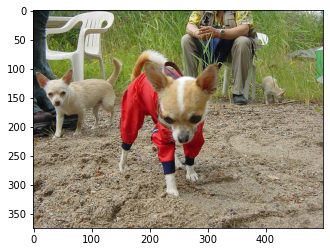

In [11]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
local_scoring_uri = local_service.scoring_uri

# Make POST request
resp = requests.post(local_scoring_uri, input_data, headers=headers)

print("POST to url", local_scoring_uri)
print("Result:", resp.text)

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [12]:
local_service.get_logs()

'2021-06-28T18:35:14,347015642+00:00 - rsyslog/run \n2021-06-28T18:35:14,347396942+00:00 - iot-server/run \n2021-06-28T18:35:14,354856853+00:00 - nginx/run \n2021-06-28T18:35:14,355629654+00:00 - gunicorn/run \nDynamic Python package installation is disabled.\nStarting HTTP server\nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-06-28T18:35:14,428733961+00:00 - iot-server/finish 1 0\n2021-06-28T18:35:14,430043463+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (11)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 41\nSPARK_HOME not set. Skipping PySpark Initialization.\nInitializing logger\n2021-06-28 18:35:16,532 | root | INFO | Starting up app insights client\nlogging socket was found. logging is available.\nlogging socket was found. logging is available.\n2021-06-28 18:35:16,533 | root | INFO | Starting up request id generator\n2021-06-28 18:35:16,533

### Local Webservice Clean Up

In [13]:
# Delete the local webservice
try:
    local_service.delete()
    print("Local service deleted.")
except:
    print("No local service.")

Container has been successfully cleaned up.
Local service deleted.


**Note**: Above SDK call will stop the container but not delete the image. When you do not require your image anymore, you should delete your images as too many images might lead your AML CI to enter an unusable state due to full disk storage.

In order to remove an image run:

`docker image rmi <IMAGE_ID> --force`

In order to prune the docker system (e.g. remove cache) run:

`docker system prune`

# Model Deployment (Compute Target)

### Option 1: Deploy to ACI (Azure Container Instances)

Create new ACI Webservice.

In [14]:
aci_config = AciWebservice.deploy_configuration(cpu_cores=1,
                                                memory_gb=1,
                                                tags=service_tags,
                                                description=service_description)

aci_service = Model.deploy(workspace=ws,
                           name=aci_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aci_config)

aci_service.wait_for_deployment(True)
print(aci_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running....................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


Retrieve existing ACI Webservice.

In [15]:
aci_service = Webservice(ws, aci_service_name)

#### ACI Webservice Testing

Test the ACI webservice using an HTTP request with the requests library.

POST to url http://f0be8c9c-2244-498d-a55b-87f2e28b9578.westeurope.azurecontainer.io/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9995623"}


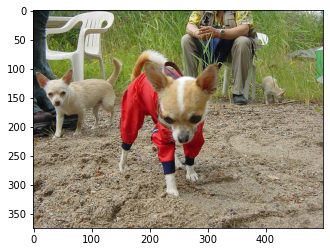

In [16]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
aci_scoring_uri = aci_service.scoring_uri

# Make POST request
resp = requests.post(aci_scoring_uri, input_data, headers=headers)

print("POST to url", aci_scoring_uri)
print("Result:", resp.text)

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [17]:
aci_service.get_logs()

'2021-06-28T19:59:40,172047499+00:00 - gunicorn/run \n2021-06-28T19:59:40,172707946+00:00 - iot-server/run \nDynamic Python package installation is disabled.\nStarting HTTP server\n2021-06-28T19:59:40,172264815+00:00 - rsyslog/run \n2021-06-28T19:59:40,240077467+00:00 - nginx/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-06-28T19:59:40,523900974+00:00 - iot-server/finish 1 0\n2021-06-28T19:59:40,530221126+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (11)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 37\nSPARK_HOME not set. Skipping PySpark Initialization.\nInitializing logger\n2021-06-28 19:59:44,905 | root | INFO | Starting up app insights client\nlogging socket was found. logging is available.\nlogging socket was found. logging is available.\n2021-06-28 19:59:44,905 | root | INFO | Starting up request id generator\n2021-06-28 19:59:44,906

### ACI Webservice Clean Up

In [18]:
# Delete the ACI webservice
try:    
    aci_service.delete()
    print("ACI service deleted.")
except:
    print("No ACI service.")

ACI service deleted.


### Option 2: Deploy to AKS (Azure Kubernetes Service)

Retrieve existing AKS cluster or provision a new one.

In [19]:
# Retrieve all computes from workspace
cts = ws.compute_targets

# Use existing cluster if available, else create a new one
if aks_name in cts and cts[aks_name].type == "AKS":
    print("Found existing AKS cluster, will use it!")
    aks_target = cts[aks_name]
else:
    print("Creating a new AKS cluster...")
    # Use the default provisioning config (no input parameters) or provide parameters to customize
    # For example, to create a dev/test cluster, use:
    prov_config = AksCompute.provisioning_configuration(cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
    # Example configuration to use an existing virtual network
    # prov_config.vnet_name = "mynetwork"
    # prov_config.vnet_resourcegroup_name = "myresourcegroup"
    # prov_config.subnet_name = "default"
    # prov_config.service_cidr = "10.0.0.0/16"
    # prov_config.dns_service_ip = "10.0.0.10"
    # prov_config.docker_bridge_cidr = "172.17.0.1/16"
    aks_target = ComputeTarget.create(workspace = ws,
                                      name = aks_name,
                                      provisioning_configuration = prov_config)
    
    print("Waiting for cluster creation completion...")
    aks_target.wait_for_completion(show_output=True)

print("Cluster state:", aks_target.provisioning_state)
print("Cluster is ready!", aks_target)

Found existing AKS cluster, will use it!
Cluster state: Succeeded
Cluster is ready! AksCompute(workspace=Workspace.create(name='mlopstemplatewsbfdc24', subscription_id='e58a23da-421e-4b52-99d5-e615f2f8be41', resource_group='mlopstemplaterg'), name=aks-cluster, id=/subscriptions/e58a23da-421e-4b52-99d5-e615f2f8be41/resourceGroups/mlopstemplaterg/providers/Microsoft.MachineLearningServices/workspaces/mlopstemplatewsbfdc24/computes/aks-cluster, type=AKS, provisioning_state=Succeeded, location=westeurope, tags=None)


Create new AKS Webservice.

In [20]:
aks_config = AksWebservice.deploy_configuration(collect_model_data=True,
                                                enable_app_insights=True)

aks_webservices = Webservice.list(workspace = ws, compute_type="AKS")

if any(aks_webservice.name == aks_service_name for aks_webservice in aks_webservices):
    print("Model with same name already deployed")
else:
    if aks_target.provisioning_state == "Succeeded":
        aks_service = Model.deploy(workspace=ws,
                                   name=aks_service_name,
                                   models=[model],
                                   inference_config=inference_config,
                                   deployment_config=aks_config,
                                   deployment_target=aks_target)
        
        aks_service.wait_for_deployment(show_output = True)
        print("Service state:", aks_service.state)
        print("Service details:", aks_service)
    else: 
        raise ValueError("Failed to deploy service to AKS - Error: ", aks_service.error)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.............................
Succeeded
AKS service creation operation finished, operation "Succeeded"
Service state: Healthy
Service details: AksWebservice(workspace=Workspace.create(name='mlopstemplatewsbfdc24', subscription_id='e58a23da-421e-4b52-99d5-e615f2f8be41', resource_group='mlopstemplaterg'), name=dog-classification-service-aks, image_id=None, compute_type=None, state=AKS, scoring_uri=Healthy, tags=http://20.101.27.17:80/api/v1/service/dog-classification-service-aks/score, properties={}, created_by={'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-mlops-template-azure-ml.git', 'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-mlops-template-azure-ml.git', 'azureml.git.branch': 'develop', 'mlflow.source.git.branch': 'develop', 'azureml.git.commit': 

Retrieve existing AKS webservice.

In [21]:
aks_service = Webservice(ws, aks_service_name)

### AKS Webservice Testing

Test the AKS webservice using an HTTP request with the requests library.

POST to url http://20.101.27.17:80/api/v1/service/dog-classification-service-aks/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9995623"}


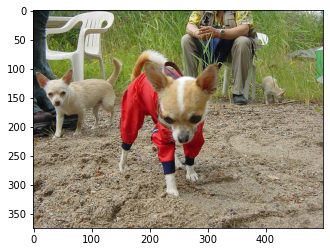

In [22]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get body and header for POST request
# For AKS deployment the service key needs to be in the header as well
# AML generate two keys if key auth is enabled
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
api_key1, api_key2 = aks_service.get_keys()
headers = {"Content-Type": "application/json", "Authorization":("Bearer "+ api_key1)} 

# Get scoring URI
aks_scoring_uri = aks_service.scoring_uri

# Make POST request
resp = requests.post(aks_scoring_uri, input_data, headers=headers)

print("POST to url", aks_scoring_uri)
print("Result:", resp.text)

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [23]:
aks_service.get_logs()

'2021-06-28T20:02:49,396743047+00:00 - gunicorn/run \n2021-06-28T20:02:49,396741847+00:00 - rsyslog/run \nDynamic Python package installation is disabled.\nStarting HTTP server\n2021-06-28T20:02:49,401748619+00:00 - iot-server/run \n2021-06-28T20:02:49,404764963+00:00 - nginx/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-06-28T20:02:49,512320021+00:00 - iot-server/finish 1 0\n2021-06-28T20:02:49,513628540+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (12)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 38\nSPARK_HOME not set. Skipping PySpark Initialization.\nInitializing logger\n2021-06-28 20:02:51,191 | root | INFO | Starting up app insights client\nlogging socket was found. logging is available.\nlogging socket was found. logging is available.\n2021-06-28 20:02:51,265 | root | INFO | Starting up request id generator\n2021-06-28 20:02:51,265

### AKS Webservice Clean Up

In [24]:
# Delete the AKS Webservice
try:    
    aks_service.delete()
    print("AKS service deleted.")
except:
    print("No AKS service.")

AKS service deleted.


# Model Deployment (Docker Image)

### Model Packaging

In some cases, you might want to create a Docker image without deploying the model directly to a compute target such as ACI or AKS (if, for example, you plan to deploy to Azure App Service). Or you might want to download the image and run it on a local Docker installation. You might even want to download the files used to build the image, inspect them, modify them, and build the image manually.

Model packaging enables you to do these things. It packages all the assets needed to host a model as a web service and allows you to download either a fully built Docker image or the files needed to build one. There are two ways to use model packaging:

**Option 1: Download a Packaged Model:** Download a Docker image that contains the model and other files needed to host it as a web service.

**Option 2: Generate a Dockerfile:** Download the Dockerfile, model, entry script, and other assets needed to build a Docker image. You can then inspect the files or make changes before you build the image locally.

Creating a package is similar to deploying a model. You use a registered model and an inference configuration. 

For more information on model packaging, check the [Microsoft documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-package-models).

### Option 1: Download a Packaged Model

The following code builds an image, which is registered in the Azure Container Registry of your AML workspace.

If the generate_dockerfile flag is set to False, then an Azure Container Registry (ACR) build task will be triggered and the image will be built on the workspace-native ACR.


In [25]:
# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=False, # Build image on ACR
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

2021/06/28 20:04:15 Downloading source code...
2021/06/28 20:04:18 Finished downloading source code
2021/06/28 20:04:18 Creating Docker network: acb_default_network, driver: 'bridge'
2021/06/28 20:04:19 Successfully set up Docker network: acb_default_network
2021/06/28 20:04:19 Setting up Docker configuration...
2021/06/28 20:04:19 Successfully set up Docker configuration
2021/06/28 20:04:19 Logging in to registry: 4d3602983f8547aa8deaeb9718806017.azurecr.io
2021/06/28 20:04:20 Successfully logged into 4d3602983f8547aa8deaeb9718806017.azurecr.io
2021/06/28 20:04:20 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/06/28 20:04:20 Launching container with name: acb_step_0
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
Login Succeeded
WARNING! Your password will be stored unencrypted in /acb/home/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine

 ---> Running in ed3964ec23cd
Removing intermediate container ed3964ec23cd
 ---> ca35f6d95261
Step 7/7 : CMD ["runsvdir","/var/runit"]
 ---> Running in 468193fa66c1
Removing intermediate container 468193fa66c1
 ---> 956cd943bf15
Successfully built 956cd943bf15
Successfully tagged 4d3602983f8547aa8deaeb9718806017.azurecr.io/azureml/azureml_dfaf2b2857f5bcc43dfddca890accc25:latest
Successfully tagged 4d3602983f8547aa8deaeb9718806017.azurecr.io/azureml/azureml_dfaf2b2857f5bcc43dfddca890accc25:1
Successfully tagged 4d3602983f8547aa8deaeb9718806017.azurecr.io/inference/dog_clf_model:1.0.0
2021/06/28 20:06:49 Successfully executed container: acb_step_1
2021/06/28 20:06:49 Executing step ID: acb_step_2. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/06/28 20:06:49 Pushing image: 4d3602983f8547aa8deaeb9718806017.azurecr.io/azureml/azureml_dfaf2b2857f5bcc43dfddca890accc25:1, attempt 1
The push refers to repository [4d3602983f8547aa8deaeb9718806017.azurecr.io/azure

Package creation Succeeded


In [26]:
# Retrieve ACR details
acr = package.get_container_registry()
print("Address:", acr.address)
print("Username:", acr.username)
print("Password:", acr.password)

Address: 4d3602983f8547aa8deaeb9718806017.azurecr.io
Username: 4d3602983f8547aa8deaeb9718806017
Password: /dG0bng3nYJiPHQnZrzCYjFi=XQ9CkWd


After a package is created, you can use package.pull() to pull the image to your local Docker environment. This can only be used if `generate_dockerfile` is set to `False`. When the package is pulled, use the `docker images` command to list the local images.

In [27]:
package.pull()

Pulling image from ACR (this may take a few minutes depending on image size)...

4d3602983f8547aa8deaeb9718806017.azurecr.io/inference/dog_clf_model@sha256:2e87c809583e724cea35b05d47f8bea8c7852293abdc17359dcd740ef59017f7: Pulling from inference/dog_clf_model
2c11b7cecaa5: Already exists
04637fa56252: Already exists
d6e6af23a0f3: Already exists
b4a424de92ad: Already exists
3e5d9ee64909: Already exists
3a846111ff22: Already exists
93a5020c6e19: Already exists
360b353e68fd: Already exists
ea4e2e1810f8: Already exists
def12cf7de15: Already exists
3ae6adfbdb11: Already exists
2a21fbf2232e: Already exists
1ef948e4af08: Already exists
2884e50fecf0: Already exists
ef1126a3f0ef: Already exists
71b767dbb69c: Already exists
9ceb021587db: Already exists
bf4f7cfc5a76: Already exists
6f7cc2038c49: Already exists
4ef44254dd51: Already exists
1d40236ff4d0: Already exists
529650b82c29: Already exists
4825efdc50fc: Already exists
18dc5c333c4d: Already exists
8041096ebae1: Pulling fs layer
b01d9c5b6634: 

### Option 2: Generate a Dockerfile

In [28]:
# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=True, # Do not build image but create a Dockerfile and deployment assets instead
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

Package creation Succeeded


After you create a Dockerfile, you can use package.save() to download the Dockerfile and corresponding artifacts to your local machine. This can only be used if `generate_dockerfile` is set to `True`.

In [29]:
package.save("../environments/docker/inferencing_image")

Logging into Docker registry 4d3602983f8547aa8deaeb9718806017.azurecr.io


In order to build the image, to push it to the ACR of the AML workspace and to run it inside a container, run the following commands from the project root directory:

Login to the Azure CLI using your device code:

`az login`

Login to the ACR:

`az acr login -n <ACR_NAME>`

Build the image:

`cd environments/docker/inferencing_image`

`docker build -t inference/dog_clf_model:1.0.0 .`

Tag the image:

`docker tag inference/dog_clf_model:1.0.0 <ACR_NAME>.azurecr.io/inference/dog_clf_model:1.0.0`

Push the image:

`docker push <ACR_NAME>.azurecr.io/inference/dog_clf_model:1.0.0`

Alternatively to the previous three steps, build the image on the ACR:

`az acr build --image inference/dog_clf_model:1.0.0 --registry <ACR_NAME> .`

### Model Packaging Local Deployment

To run the image on your local compute target (e.g. AML CI), run the following:

`docker run -p 6789:5001 --name dog-clf-container -it inference/dog_clf_model:1.0.0`

This command starts a container with the 1.0.0 version of the image named `inference/dog_clf_model` (in interactive mode). It maps local port 6789 to the port in the container on which the web service is listening (5001). It also assigns the name dog-clf-container to the container, which makes the container easier to stop. After the container is started, you can submit requests to http://localhost:6789/score.

To see the running container run:

`docker ps`


### Model Packaging Local Webservice Testing

POST to url http://localhost:6789/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9995623"}


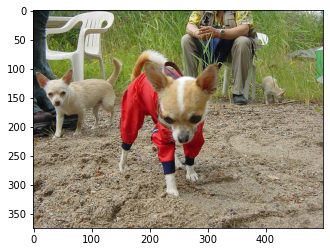

In [30]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Make POST request
resp = requests.post("http://localhost:6789/score", input_data, headers=headers)

print("POST to url", local_scoring_uri)
print("Result:", resp.text)

### Model Packaging Clean Up

To stop the running container run:

`docker stop dog-clf-container`

Do not forget to clean up the image:

`docker images`

`docker image rmi <IMAGE_ID> --force`

Test the local webservice using an HTTP request with the requests library.

### Deploy Docker Image to AKS

We will use kubectl (the Kubernetes CLI) to deploy the image to AKS.

First, create a Kubernetes manifest to deploy the stanford dogs inferencing image to AKS. Replace `<ACR_NAME>` with the name of your ACR.

In [38]:
%%writefile ../infrastructure/aks_deployment/aks_deployment_manifest.yml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: dog-clf-deployment
spec:
  replicas: 1
  selector:
    matchLabels:
      app: dog-clf-app
  template:
    metadata:
      labels:
        app: dog-clf-app
    spec: 
      containers:
      - image: <ACR_NAME>.azurecr.io/inference/dog_clf_model:1.0.0
        name: dog-clf-container
---
apiVersion: v1
kind: Service
metadata:
  labels:
    app: dog-clf-service
  name: dog-clf-service
spec:
  ports:
  - targetPort: 5001
    port: 80
    protocol: TCP
  selector:
    app: dog-clf-app
  type: LoadBalancer

Overwriting ../infrastructure/aks_deployment/aks_deployment_manifest.yml


Create a shell script to attach the ACR to AKS, configure kubectl to connect to AKS and run the deployment manifest:

In [37]:
%%writefile ../infrastructure/aks_deployment/execute_aks_deployment.sh
# Define parameters
resourceGroupName=mlopstemplaterg
region=westeurope

# Install kubectl
sudo az aks install-cli

# Attach ACR to AKS cluster
az aks update \
    --resource-group $resourceGroupName \
    --name $aksClusterName \
    --attach-acr $acrName

# Configure kubectl to connect to the AKS cluster
az aks get-credentials \
    --resource-group $resourceGroupName \
    --name $aksClusterName

# Apply kubernetes manifest
kubectl apply -f aks_deployment_manifest.yml

Overwriting ../infrastructure/aks_deployment/execute_aks_deployment.sh


Define two environment variables:

`export aksClusterName=<AKS_CLUSTER_NAME>` and `export acrName=<ACR_NAME>`

where `<AKS_CLUSTER_NAME>` and `<ACR_NAME>` are replaced by your template-specific values.

Then run the following from the project root directory to deploy the image to AKS:

`cd infrastructure/aks_deployment`

`bash execute_aks_deployment.sh`

Check whether the container was successfully deployed:

`kubectl get pods`

Check webservice status and retrieve external IP:

`kubectl get service dog-clf-service --watch`

### Test the Deployed Webservice

Insert the external IP from above command into the POST request below.

{"label": "n02085620-Chihuahua", "probability": "0.9995623"}


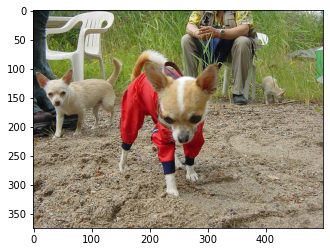

In [39]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Make the request and display the response.
# Add the external IP from above watch command in below web request
resp = requests.post("http://<EXTERNAL_IP>/score", input_data, headers=headers)
print(resp.text)

### Model Packaging Webservice Clean Up

To remove the AKS deployment and service, you can run:
    
`kubectl delete deployment dog-clf-deployment`

`kubectl delete service dog-clf-service`

# Resource Clean Up

Delete the AKS cluster.

In [ ]:
# aks_target.delete()